# ONNX Model Deployment & End-to-End Machine Learning Pipeline


# **1. Install Dependencies and Import Libraries**

 Installing the necessary packages and import libraries required for the exploratory data analysis (EDA) and further steps.


In [1]:
!pip install onnxruntime


# **2. Load Dataset and Initial Exploration**

Loading the dataset, slice the first 1000 observations, and perform an initial exploration to understand the structure and data types.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/data_public.csv")



# **3. Exploratory Data Analysis (EDA)**

visualizing and analyzing the dataset through different methods like histograms, box plots, and correlation heatmaps to understand the distribution and relationships between features.


In [3]:
# Slice the first 1000 observations
df = df.iloc[:1000]
df.info()

# Dataset Overview: Check basic stats and info
print("Dataset Overview")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   C       1000 non-null   float64
 3   D       1000 non-null   float64
 4   E       1000 non-null   float64
 5   F       1000 non-null   float64
 6   G       1000 non-null   float64
 7   H       1000 non-null   float64
 8   I       1000 non-null   float64
 9   J       1000 non-null   float64
 10  K       1000 non-null   float64
 11  L       1000 non-null   float64
 12  M       1000 non-null   float64
 13  N       1000 non-null   float64
 14  O       1000 non-null   float64
 15  Class   1000 non-null   float64
dtypes: float64(16)
memory usage: 125.1 KB
Dataset Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  ------------

In [4]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())




Missing values per column:
A        0
B        0
C        0
D        0
E        0
F        0
G        0
H        0
I        0
J        0
K        0
L        0
M        0
N        0
O        0
Class    0
dtype: int64


In [5]:
# Class distribution (check for imbalance)
print("\nClass distribution:")
print(df['Class'].value_counts())

# Univariate Analysis: Visualize numerical features
numerical_columns = df.select_dtypes(include=['float64']).columns




Class distribution:
Class
3.0    448
2.0    402
1.0    150
Name: count, dtype: int64


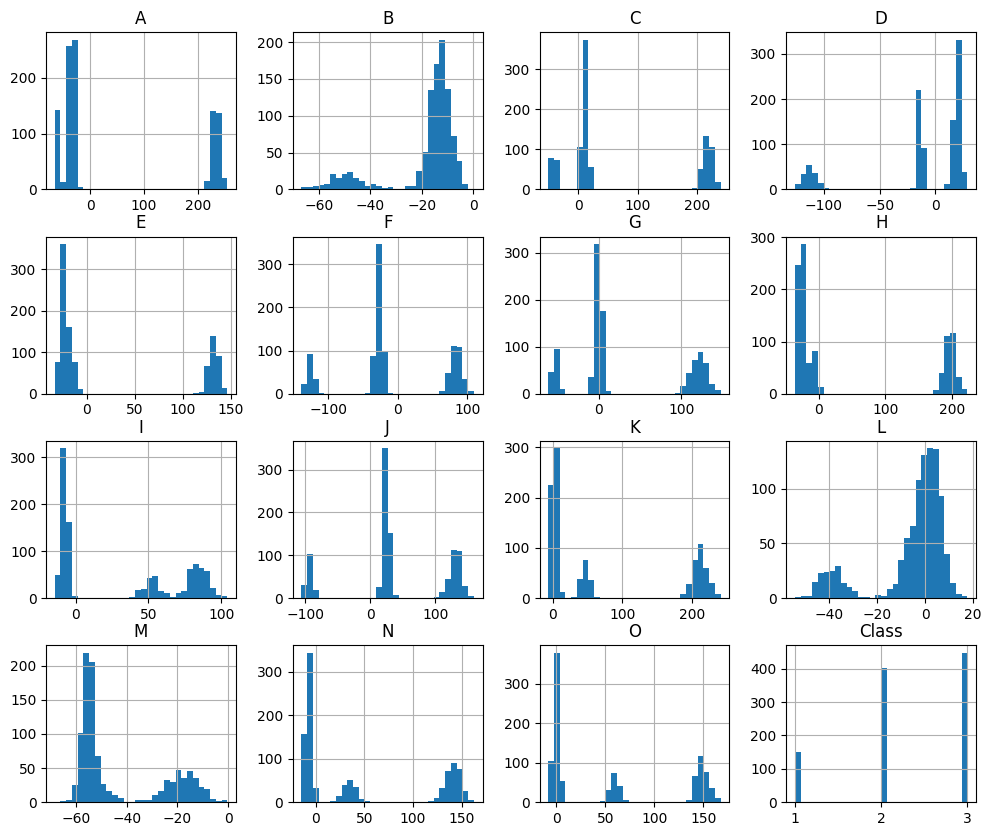

In [6]:
# Histograms
df[numerical_columns].hist(figsize=(12, 10), bins=30)
plt.show()



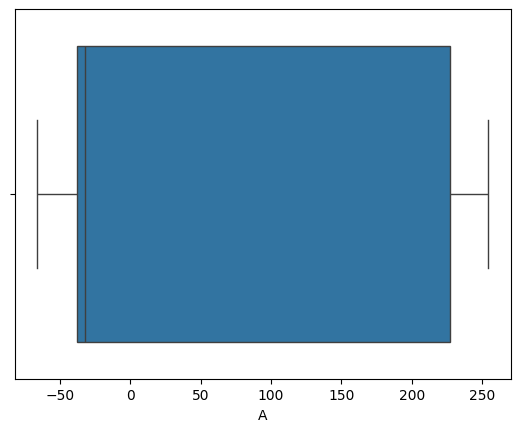

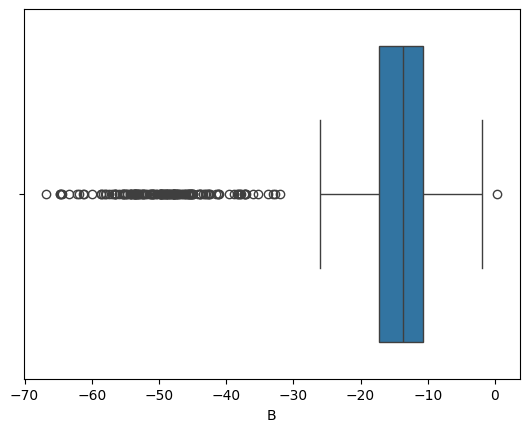

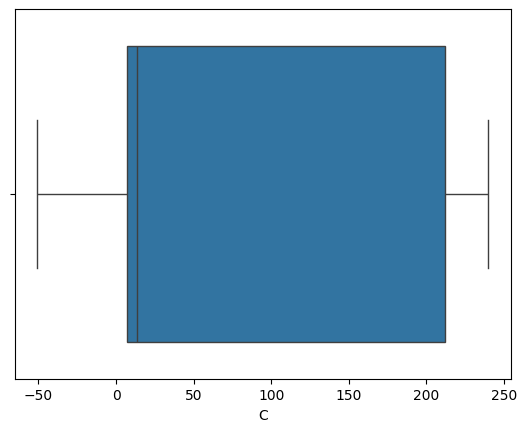

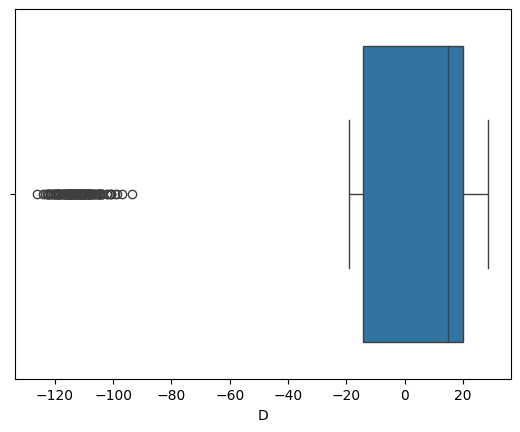

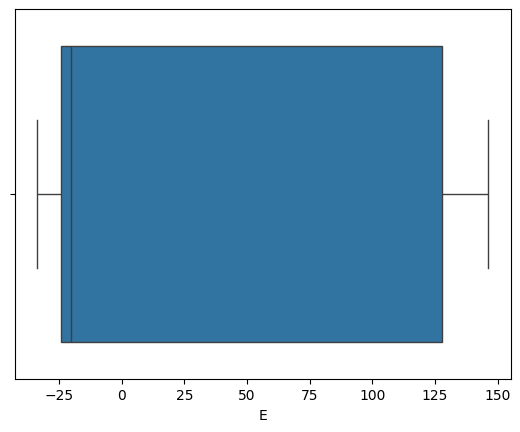

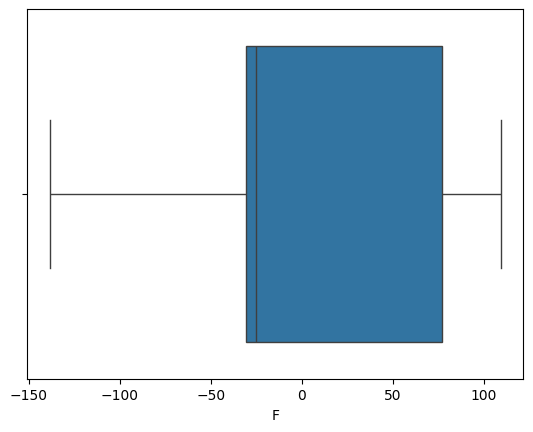

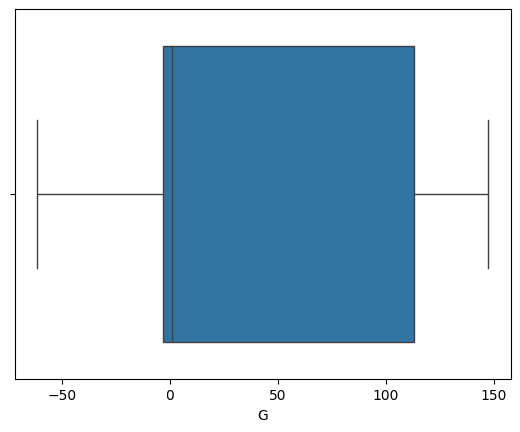

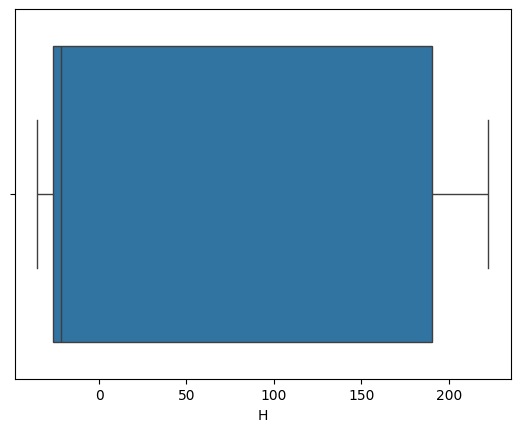

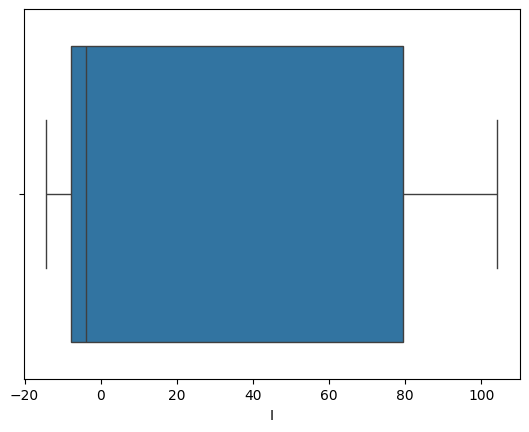

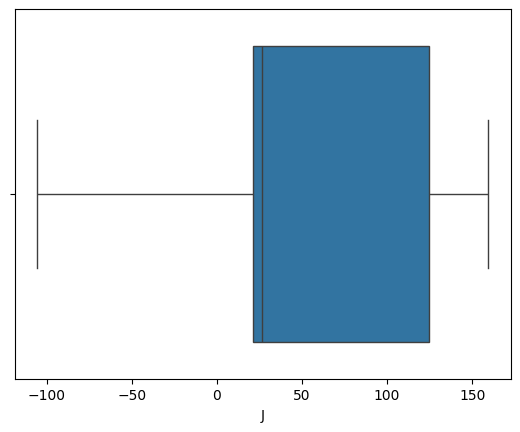

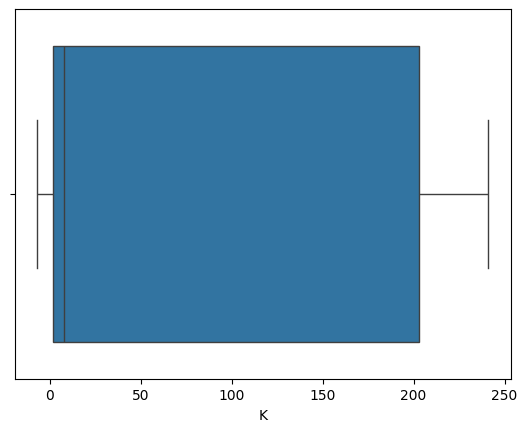

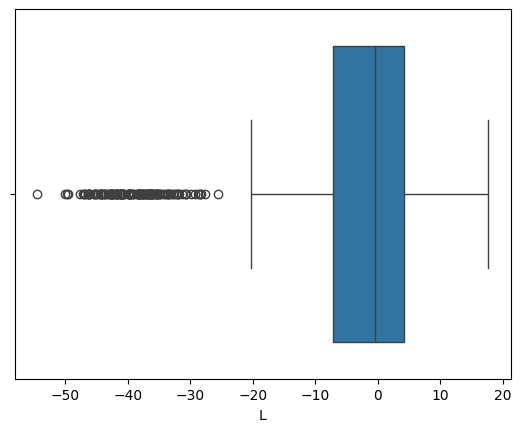

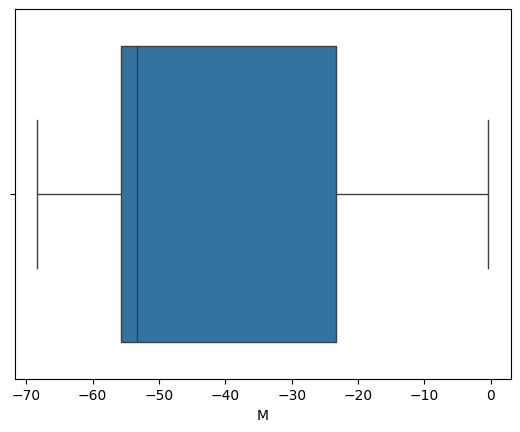

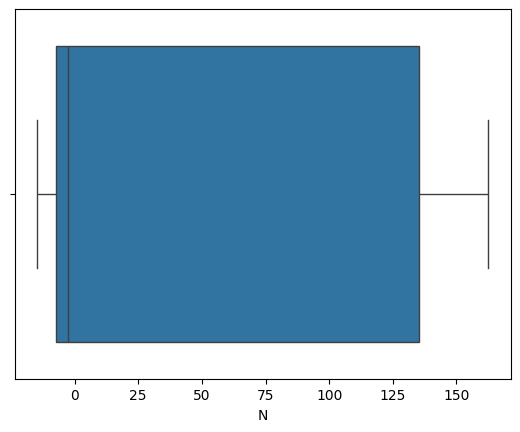

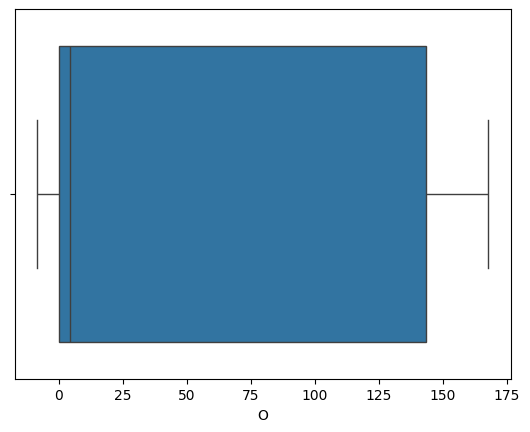

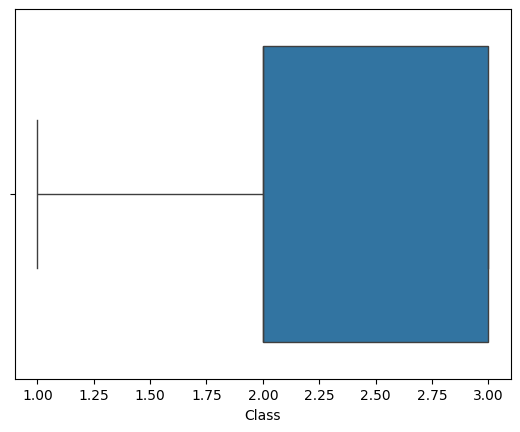

In [7]:
# Box plots
for col in numerical_columns:
    sns.boxplot(x=df[col])
    plt.show()



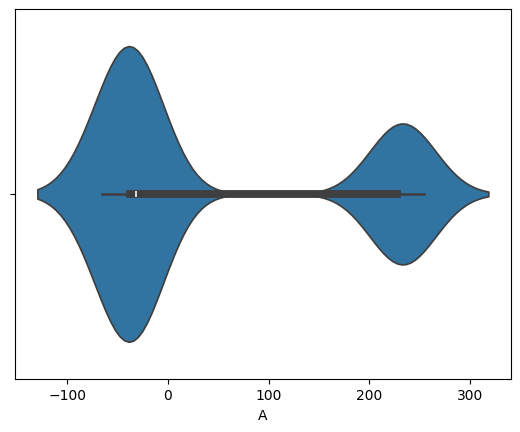

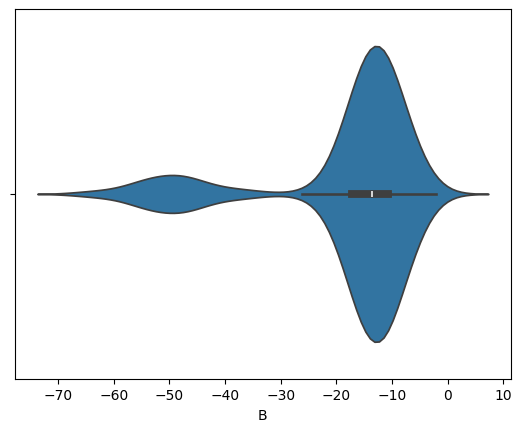

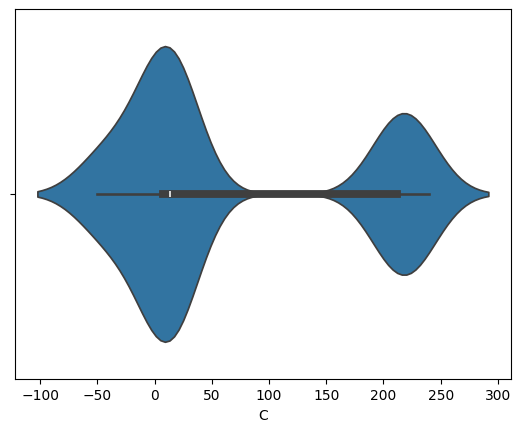

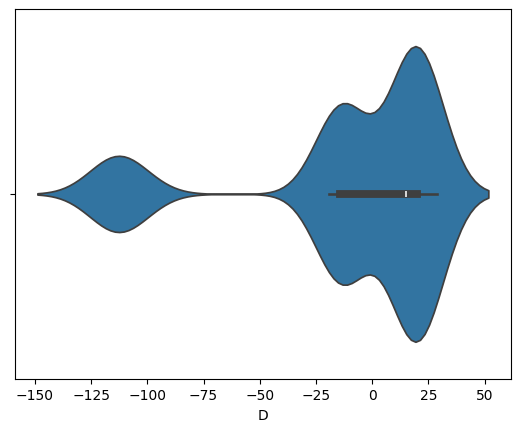

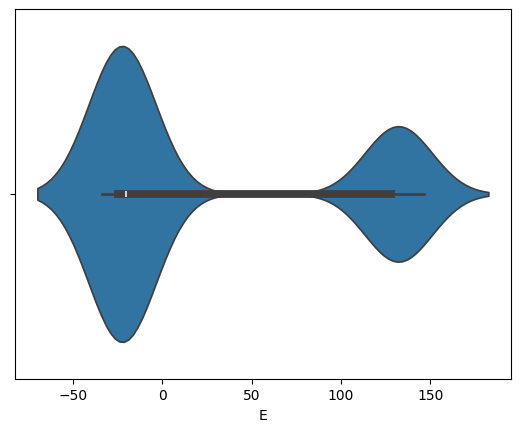

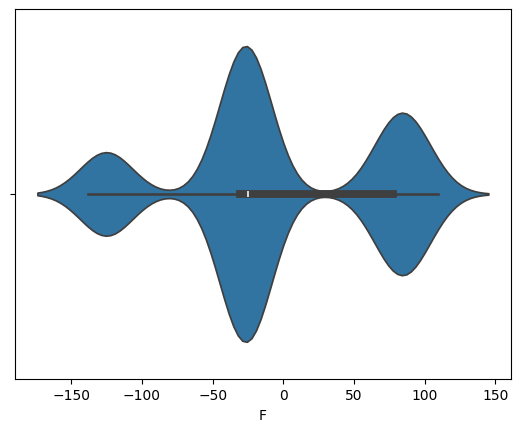

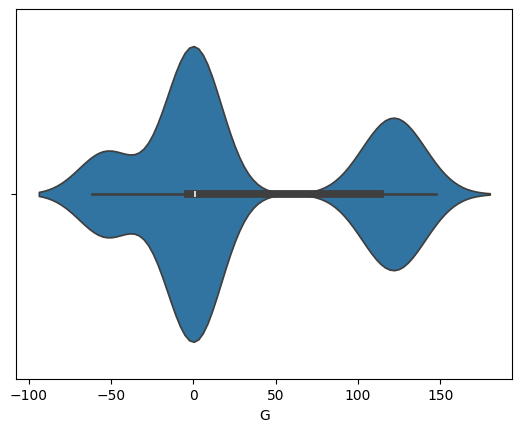

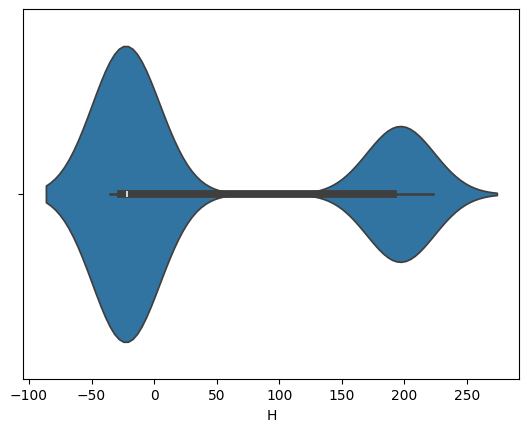

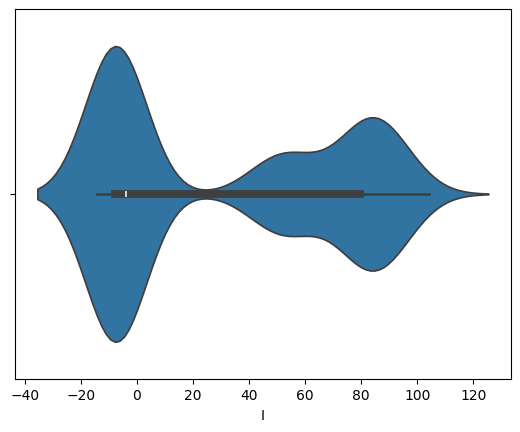

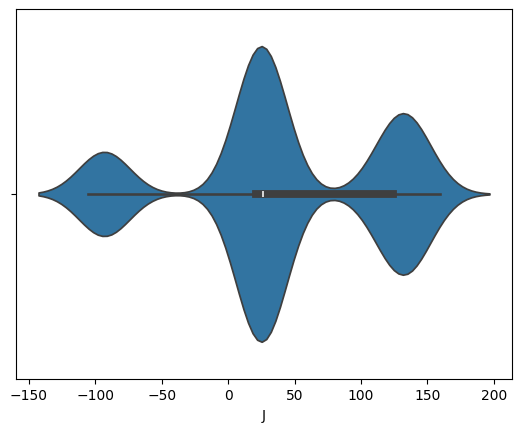

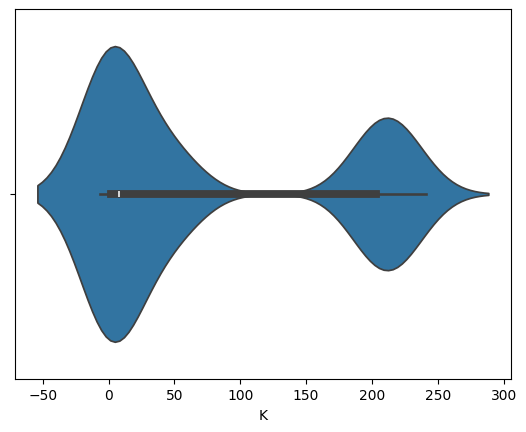

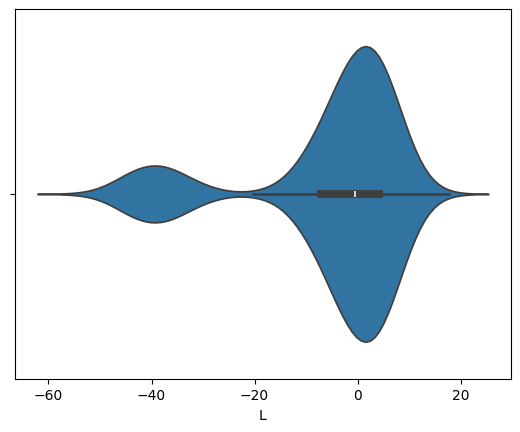

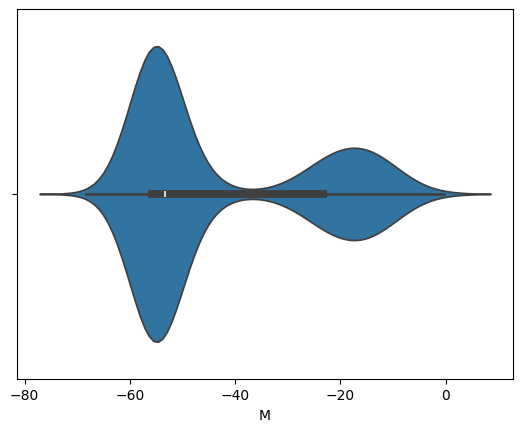

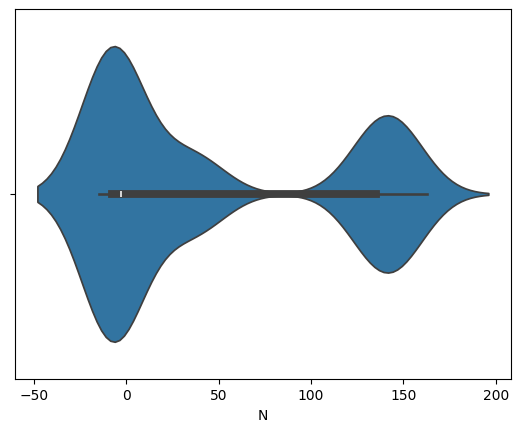

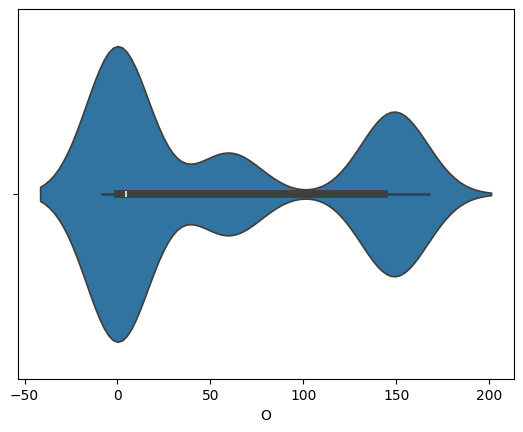

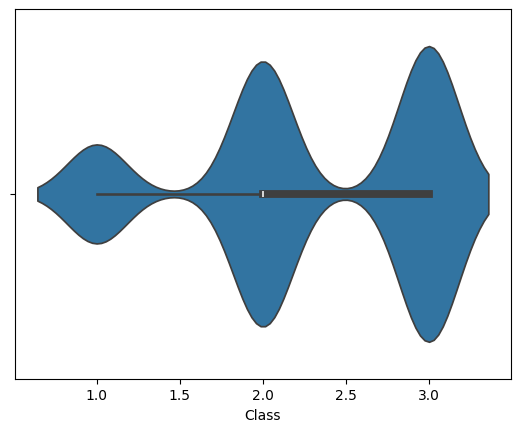

In [8]:
# Violin plots
for col in numerical_columns:
    sns.violinplot(x=df[col])
    plt.show()


In [9]:

# Handling Outliers with IQR method
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR)))



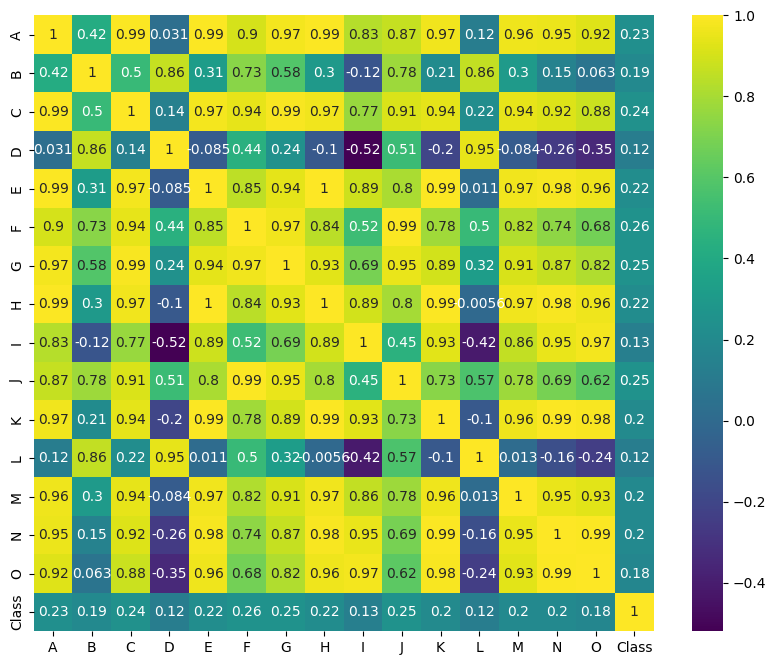

In [10]:
# Bivariate Analysis
# Correlation matrix
corr = df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='viridis')
plt.show()



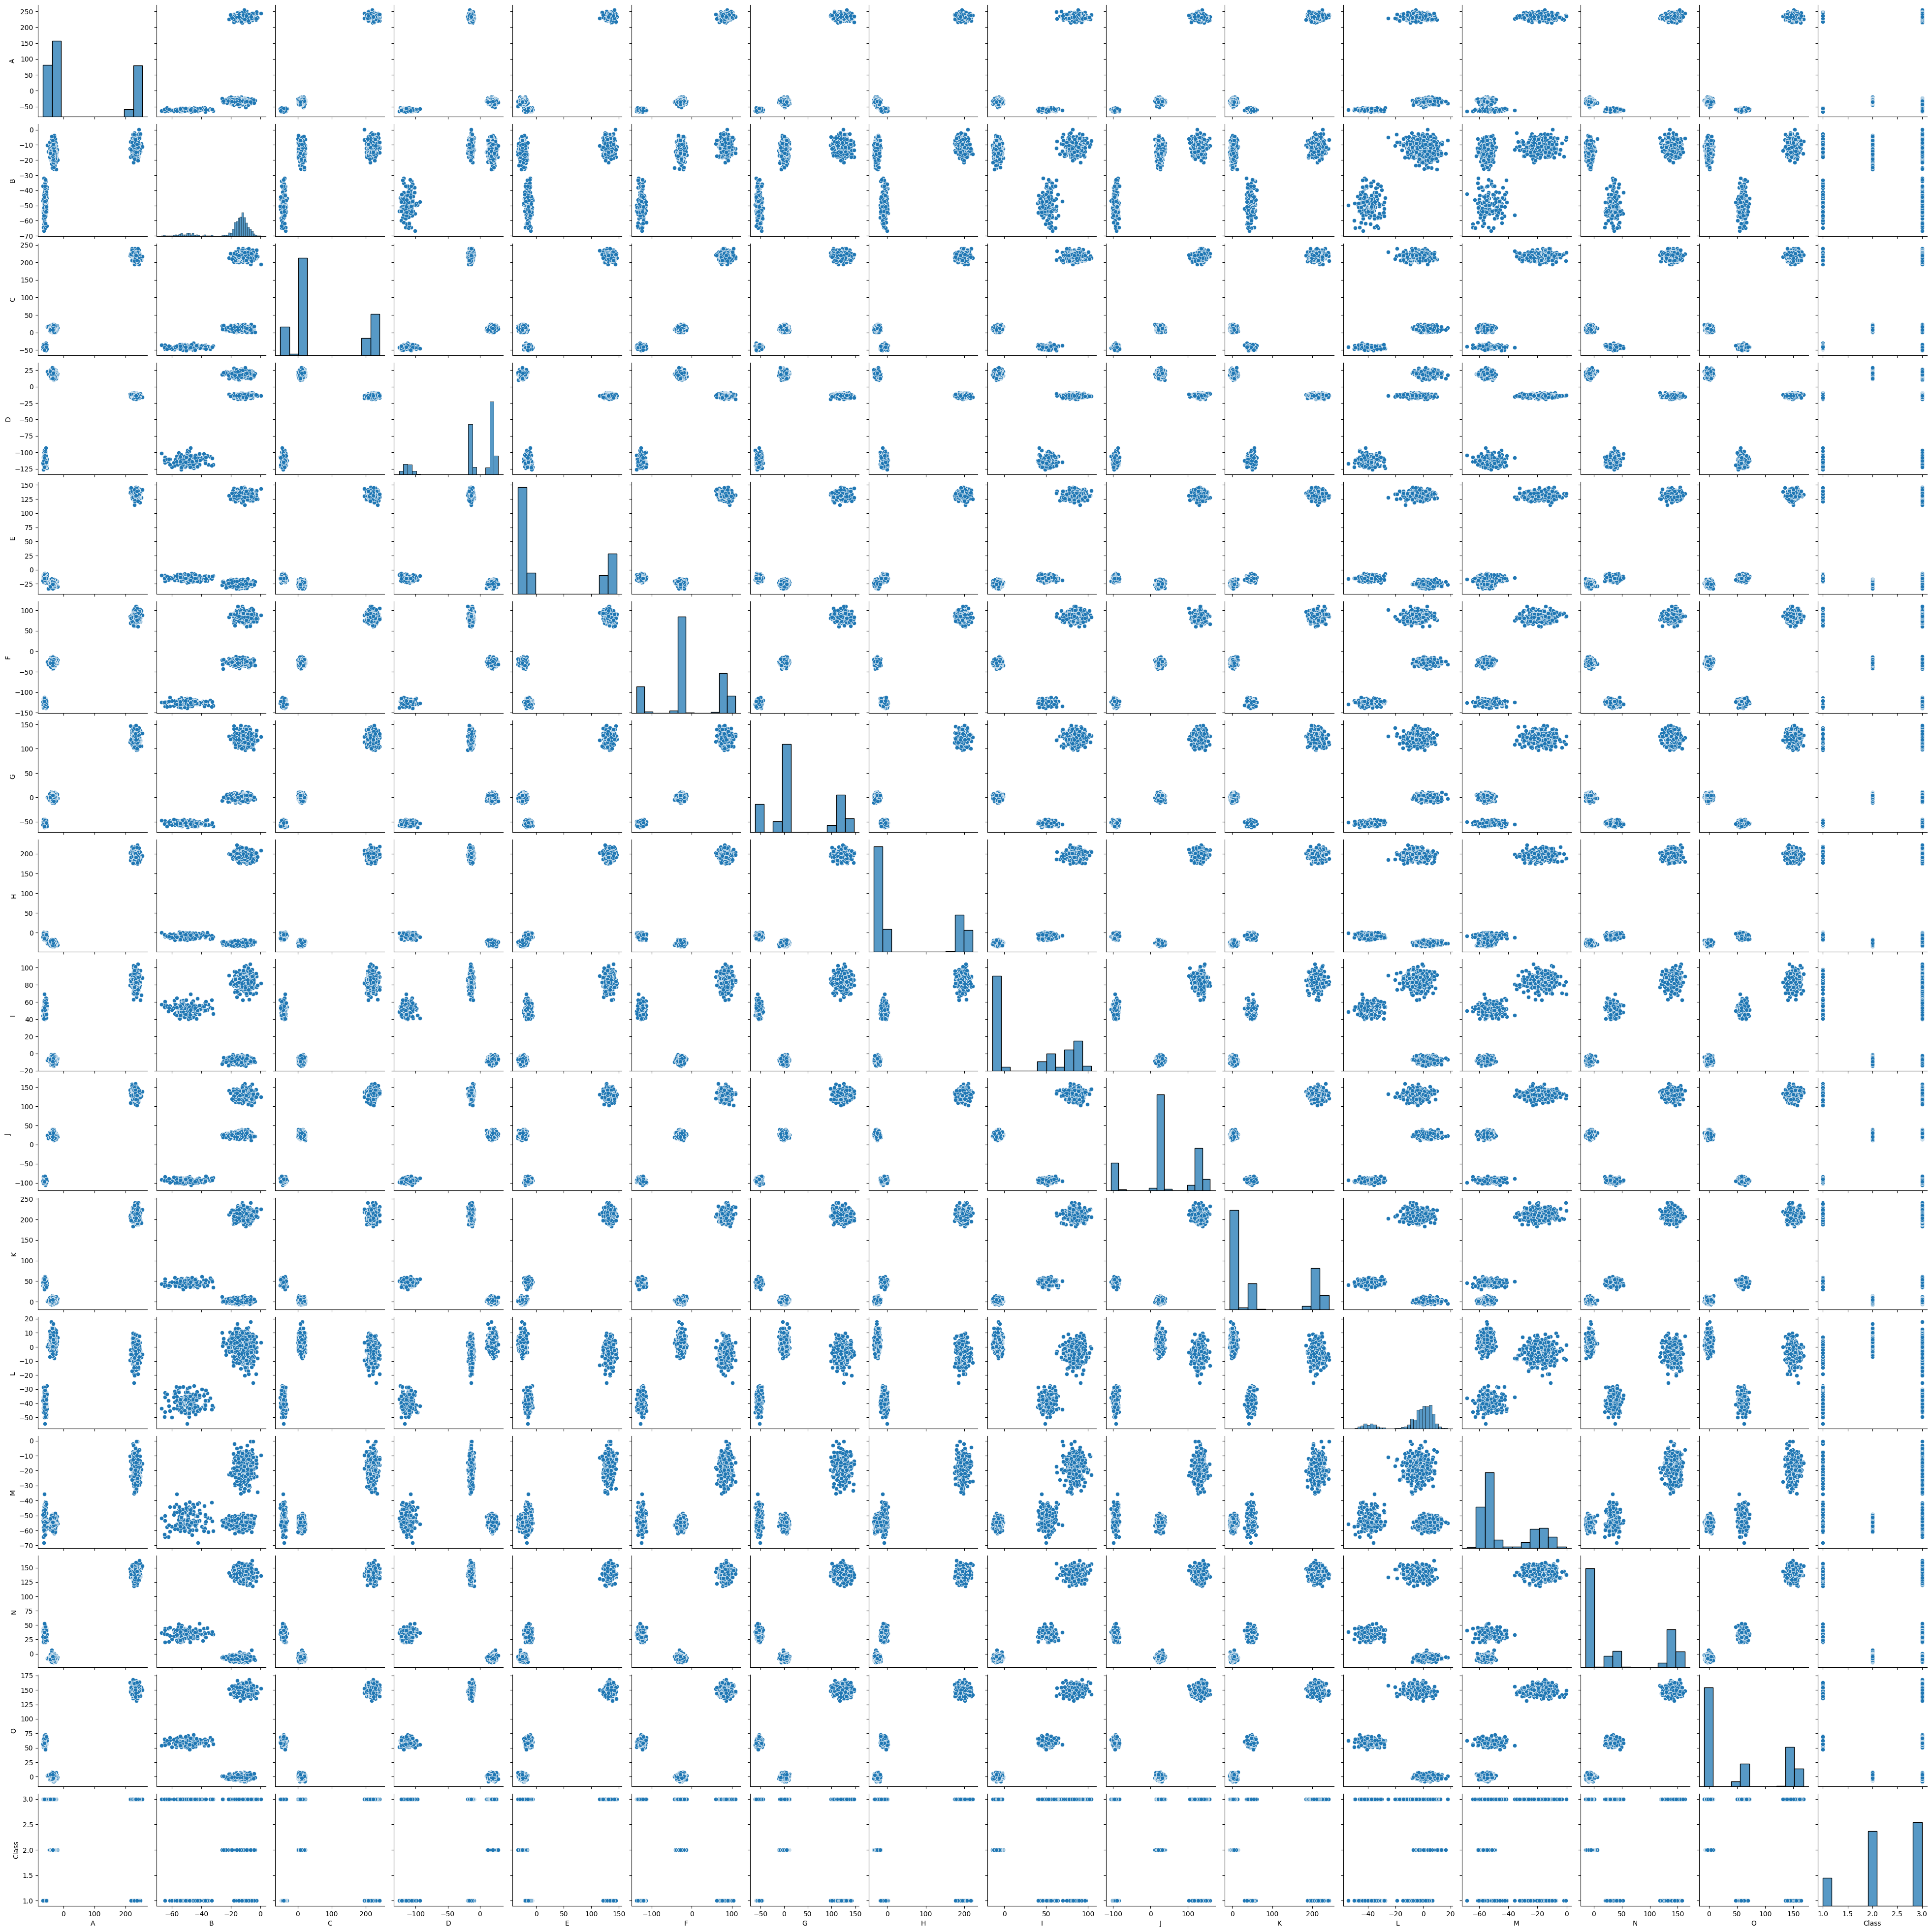

In [11]:
# Scatter plots
sns.pairplot(df[numerical_columns])
plt.show()



In [12]:
# Categorical features analysis
categorical_columns = df.select_dtypes(include=['object']).columns



In [13]:
# Bar plots for categorical features
for col in categorical_columns:
    sns.countplot(x=df[col])
    plt.show()



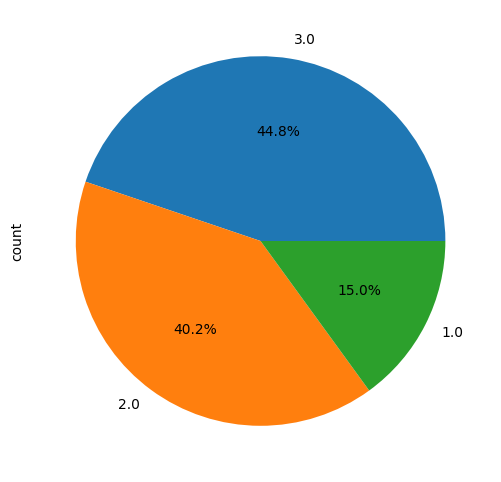

In [14]:
# Pie charts for class distribution
df['Class'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.show()

# **4. Data Preprocessing**

 handling missing values, feature scaling, and applying transformations such as SMOTE for handling class imbalance.


In [15]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import joblib


# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# --- Step 1: Handle Missing Values ---
# Drop rows with missing target variable (NaN in y)
df_clean = df.dropna(subset=['Class'])

# Update X and y after dropping rows with NaN in the target
X = df_clean.drop(columns=['Class'])
y = df_clean['Class']

# Create separate imputers for numerical and categorical features
num_cols = X.select_dtypes(include=['float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Define different imputation strategies for numerical and categorical columns
num_imputer = SimpleImputer(strategy='mean')  # Numerical columns will be imputed with mean
cat_imputer = SimpleImputer(strategy='most_frequent')  # Categorical columns with the most frequent value

# Define the column transformer to apply imputers for different types of columns
preprocessor = ColumnTransformer(
    transformers=[
        # Numerical columns
        ('num', num_imputer, num_cols),
        # Categorical columns
        ('cat', Pipeline(steps=[
            ('imputer', cat_imputer),  # Impute missing categorical data
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
        ]), cat_cols)
    ],
    remainder='passthrough'  # Leave non-processed columns as is (if any)
)

# --- Step 2: Define the Full Preprocessing Pipeline ---
pipeline = Pipeline(steps=[
    # Step 1: Preprocessing with column transformer (handles missing data)
    ('preprocessing', preprocessor),

    # Step 2: Feature Engineering (Polynomial Features)
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),

    # Step 3: Scaling/Normalization
    ('scaler', StandardScaler()),

    # Step 4: Model Training (e.g., RandomForestClassifier)
    ('classifier', RandomForestClassifier(random_state=42))
])

# --- Step 3: Train-Test Split ---
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 4: Apply SMOTE after preprocessing ---
# Apply SMOTE on the training set to address class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# --- Step 5: Fit the pipeline on the resampled data ---
# Fit the pipeline on the resampled data
pipeline.fit(X_res, y_res)

# --- Step 6: Save the Preprocessing Pipeline ---
# Save the entire preprocessing pipeline to a file using joblib
joblib.dump(pipeline, 'preprocessing_pipeline.pkl')

# Check if the pipeline is saved correctly
print("Preprocessing pipeline saved to 'preprocessing_pipeline.pkl'")

# --- Step 7: Evaluate the Model ---
# Evaluate the model on the test set using predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy score
from sklearn.metrics import accuracy_score
test_score = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_score:.4f}")


Preprocessing pipeline saved to 'preprocessing_pipeline.pkl'
Test set accuracy: 0.7100


In [16]:
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', SimpleImputer(),
                                                  Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('poly_features',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [17]:
# Print the column names in dataset
print(X.columns)


Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O'],
      dtype='object')


# **6. Feature Engineering**
Creating interaction terms, polynomial features, and domain-specific transformations such as logarithmic and square transformations.


In [18]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# 1. Interaction Terms: Create interaction terms between features
interaction_terms = X_train.copy()
for col1 in X_train.columns:
    for col2 in X_train.columns:
        if col1 != col2:  #  fine-tune this for specific columns if needed
            interaction_terms[f'{col1}_x_{col2}'] = X_train[col1] * X_train[col2]

# 2. Polynomial Features: Adding polynomial terms for non-linear relationships
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(X_train)

# Convert the polynomial features back to a DataFrame
poly_feature_names = poly.get_feature_names_out(X_train.columns)
poly_features_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Combine the polynomial features with the original dataset
X_train_poly = pd.concat([X_train, poly_features_df], axis=1)

# 3. Domain-Specific Features: Apply any domain-specific knowledge
# Example: If column 'A' is skewed, apply log transformation
X_train['LogA'] = np.log1p(X_train['A'])  # Apply log transformation for skewed features

# If other columns are skewed, apply similar transformations
X_train['LogB'] = np.log1p(X_train['B'])  # Another example for column 'B'

#  apply square transformation for quadratic relationships
X_train['A_squared'] = np.square(X_train['A'])
X_train['B_squared'] = np.square(X_train['B'])

#  apply square root transformation for highly skewed features
X_train['sqrtA'] = np.sqrt(X_train['A'])
X_train['sqrtB'] = np.sqrt(X_train['B'])

#


<ipython-input-18-96c23dfa74d3>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interaction_terms[f'{col1}_x_{col2}'] = X_train[col1] * X_train[col2]
<ipython-input-18-96c23dfa74d3>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interaction_terms[f'{col1}_x_{col2}'] = X_train[col1] * X_train[col2]
<ipython-input-18-96c23dfa74d3>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

# **7. Feature Selection/Extraction**
Perform correlation analysis to identify highly correlated features and drop them if necessary.


Filter Methods: Correlation Analysis
Correlation analysis can help identify highly correlated features, which may be redundant. If features are highly correlated (e.g., greater than a threshold like 0.9),  drop one of the correlated features.

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix of the features
correlation_matrix = X_train_poly.corr()

# # Visualize the correlation matrix (optional but recommended for better understanding)
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Correlation Matrix')
# plt.show()

# Identify highly correlated features (with correlation > 0.9)
corr_threshold = 0.9
high_corr_vars = set()

# Iterate through the correlation matrix to find highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_vars.add(colname)

# Drop the highly correlated features from the dataset
X_train_filtered = X_train_poly.drop(columns=high_corr_vars)

# Print the dropped features
print("Dropped highly correlated features:", high_corr_vars)

# Optionally, check the shape of the filtered dataset
print(f"Shape of the dataset after removing highly correlated features: {X_train_filtered.shape}")


Dropped highly correlated features: {'B L', 'D O', 'I K', 'J K', 'J O', 'D J', 'C G', 'F M', 'G N', 'H I', 'I N', 'D G', 'A F', 'A B', 'D E', 'A J', 'A N', 'H M', 'F O', 'L^2', 'G M', 'K M', 'C H', 'A E', 'N^2', 'B C', 'B M', 'D M', 'G I', 'E K', 'A M', 'A G', 'G K', 'C O', 'B E', 'F N', 'C E', 'K N', 'L M', 'D I', 'K O', 'F G', 'I J', 'M O', 'E H', 'G', 'L', 'B F', 'E', 'J M', 'F H', 'F', 'B O', 'A K', 'L N', 'I O', 'G H', 'E J', 'E^2', 'B^2', 'N O', 'K', 'H O', 'J N', 'H K', 'A D', 'M^2', 'F J', 'F^2', 'N', 'F L', 'C F', 'D N', 'E O', 'H', 'C N', 'E L', 'I L', 'D H', 'E I', 'O^2', 'K^2', 'C^2', 'J', 'D K', 'A^2', 'M', 'F K', 'G^2', 'J^2', 'C J', 'F I', 'E F', 'D F', 'H^2', 'C I', 'C D', 'B I', 'C L', 'E N', 'A I', 'B D', 'H N', 'H L', 'G O', 'D L', 'I^2', 'D^2', 'M N', 'E G', 'E M', 'L O', 'B G', 'A O', 'B J', 'I M', 'B N', 'H J', 'C K', 'C', 'C M', 'A C', 'G L', 'J L', 'A H', 'G J', 'B H', 'O'}
Shape of the dataset after removing highly correlated features: (956, 11)


# **8. Model Training and Evaluation**

Define and train multiple machine learning models including Logistic Regression, Random Forest, and Gradient Boosting. The models will be evaluated using accuracy.


Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Random Forest...
Training Gradient Boosting...
Training K-Nearest Neighbors...
                     Accuracy  Training Time
Logistic Regression     0.640       1.318274
Random Forest           0.685       1.547535
Gradient Boosting       0.645       3.804287
K-Nearest Neighbors     0.625       0.004363


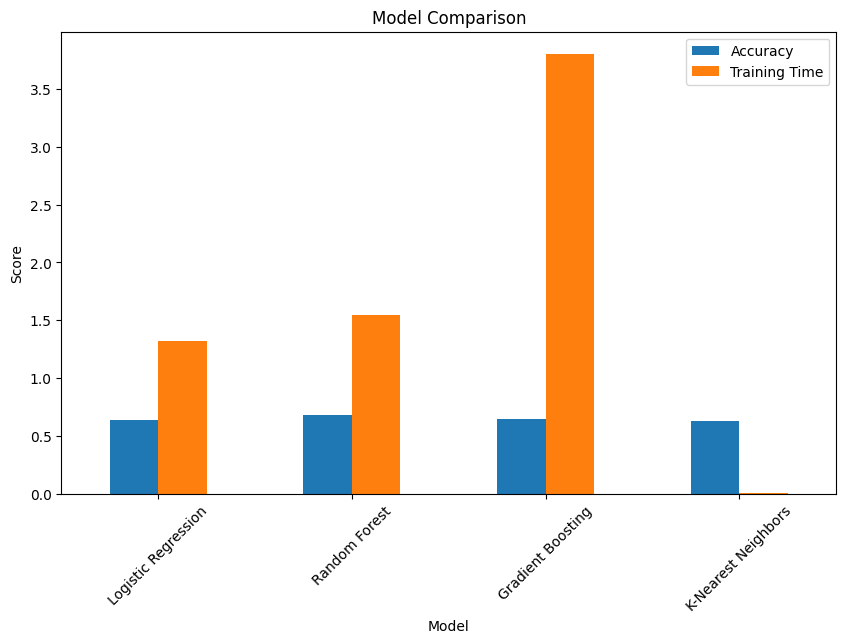

The best model is: Random Forest with accuracy: 0.6850


In [20]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from time import time

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Initialize dictionaries to store results
model_results = {}

# --- Step 1: Train and Evaluate Models ---
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Record the start time for training
    start_time = time()

    # Fit the model on the resampled data (X_train_res, y_train_res)
    model.fit(X_res, y_res)

    # Record the end time for training
    end_time = time()

    # Calculate training time
    training_time = end_time - start_time

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store the results in the dictionary
    model_results[model_name] = {
        'Accuracy': accuracy,
        'Training Time': training_time
    }

# --- Step 2: Display the Results ---
# Print the results for all models
results_df = pd.DataFrame(model_results).T
print(results_df)

# Optionally, visualize the results
results_df[['Accuracy', 'Training Time']].plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

# Find the best performing model based on accuracy
best_model_name = results_df['Accuracy'].idxmax()
best_model = models[best_model_name]

print(f"The best model is: {best_model_name} with accuracy: {results_df['Accuracy'].max():.4f}")


# **5. Hyperparameter Tuning with Grid Search**

perform hyperparameter tuning using **GridSearchCV** to find the best combination of hyperparameters for our model. GridSearchCV automates the process of testing multiple combinations of hyperparameters to find the one that optimizes model performance. Using **StratifiedKFold Cross-Validation** to ensure that each fold has the same proportion of target classes.


In [21]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Select the best model from previous step
best_model_name = 'Random Forest'
best_model = RandomForestClassifier(random_state=42)

# Simplified Grid Search with fewer parameters
param_grid = {
    'n_estimators': [50, 100],  # Use fewer values for faster grid search
    'max_depth': [None, 10],  # Limit max depth
    'min_samples_split': [2, 5],  # Simpler values for faster testing
}

# Stratified K-Fold Cross-Validation (use fewer splits to save time)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use GridSearchCV with a simplified grid
grid_search = GridSearchCV(best_model, param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=1)

# Fit the grid search on the resampled training data
grid_search.fit(X_res, y_res)

# Best hyperparameters from grid search
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Use the best model found by GridSearchCV
best_model_tuned = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model_tuned.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")



Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Test Set Accuracy: 0.6850


In [22]:
param_grid

{'n_estimators': [50, 100],
 'max_depth': [None, 10],
 'min_samples_split': [2, 5]}

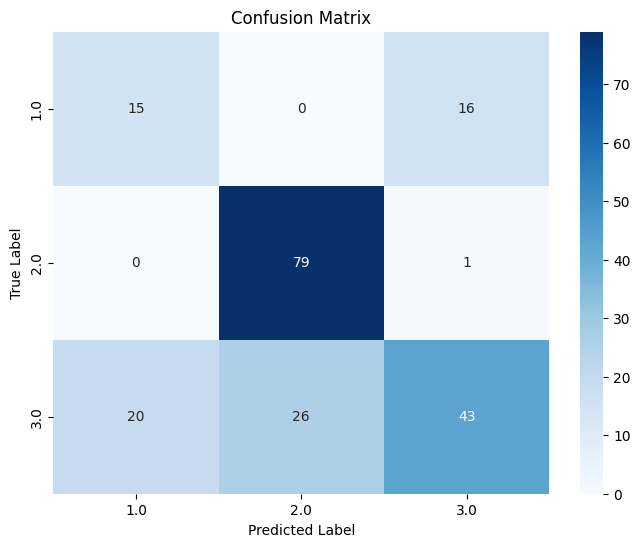

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### **6. Model Re-Training, Evaluation, and Export to ONNX Format**

Demonstrates the complete process of training a machine learning model, evaluating its performance using key metrics, and exporting it to the ONNX format for deployment.



Accuracy: 0.7200
Precision: 0.7047
Recall: 0.7200
F1-Score: 0.7027
ROC-AUC: 0.8361


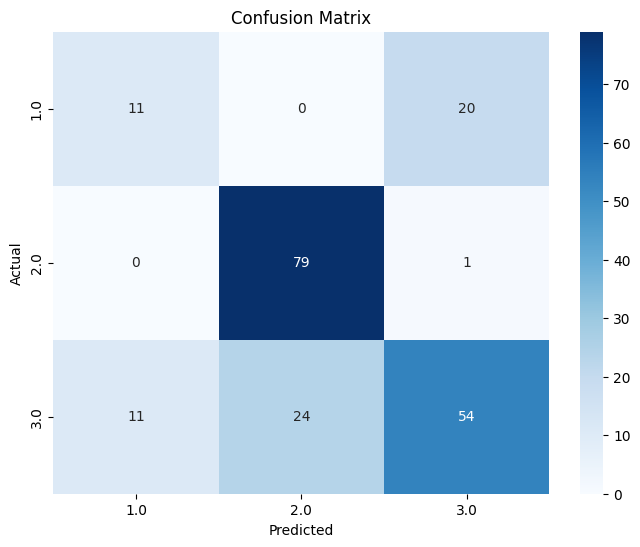

Model saved to model.onnx


In [24]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import onnxmltools
import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

import onnxruntime as ort


X = df.drop(columns=['Class'])
y = df['Class']

# --- Step 1: Preprocessing ---
# Handle missing values, standardization, etc.
# For simplicity,  already preprocessed X_train and X_test, and split data

# --- Step 2: Feature Engineering ---
# Add polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(X)

# Combine polynomial features with the original dataset
poly_feature_names = poly.get_feature_names_out(X.columns)
X_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

# --- Step 3: Model Training ---
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Model selection (RandomForestClassifier as example)
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# --- Step 4: Model Evaluation ---
# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # for multiclass
recall = recall_score(y_test, y_pred, average='weighted')  # for multiclass
f1 = f1_score(y_test, y_pred, average='weighted')  # for multiclass
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')  # ROC-AUC for multiclass

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Step 5: Export Model to ONNX ---

# Define the input type for the model
initial_types = [('input', FloatTensorType([None, X_train.shape[1]]))]

# Convert the trained model to ONNX format using skl2onnx
onnx_model = convert_sklearn(model, initial_types=initial_types)

# Save the model to a file
onnx_file_path = "model.onnx"
onnx.save_model(onnx_model, onnx_file_path)

print(f"Model saved to {onnx_file_path}")




### **7. Model Inference and Evaluation Using ONNX Runtime**

Demonstrates how to perform inference on an ONNX model using `onnxruntime` and evaluate the model's performance on test data.

`

In [25]:
import onnxruntime as ort
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Step 1: Load the ONNX model ---
onnx_model_path = "model.onnx"
session = ort.InferenceSession(onnx_model_path)

# --- Step 2: Prepare the input data (same format as training data) ---
# Convert X_test to numpy array (if it's not already a numpy array)
X_test_onnx = X_test.to_numpy().astype(np.float32)  # Ensure it has the correct data type

# --- Step 3: Run the model on the test data ---
input_name = session.get_inputs()[0].name  # The input name in the ONNX model
output_name = session.get_outputs()[0].name  # The output name in the ONNX model

# Perform inference
y_pred_onnx = session.run([output_name], {input_name: X_test_onnx})[0]

# --- Step 4: Check the shape of predictions and adjust handling ---
print("Shape of predictions:", y_pred_onnx.shape)

# If output is a 1D array (class labels directly)
if len(y_pred_onnx.shape) == 1:
    y_pred_classes = y_pred_onnx
else:
    # If output is a 2D array (probabilities), apply argmax to get class labels
    y_pred_classes = np.argmax(y_pred_onnx, axis=1)

# --- Step 5: Evaluate the predictions ---
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Shape of predictions: (200,)
Accuracy: 0.7200
Precision: 0.7047
Recall: 0.7200
F1-Score: 0.7027
